In [ ]:
import pandas as pd

# Veri setini yükle
df = pd.read_csv("turkish_toxic_language.csv")

# "target" sütunundaki değerleri farklı sütunlar olarak ayarla ve etiketle
df['INSULT'] = df['target'].apply(lambda x: 1 if x == 'INSULT' else 0)
df['PROFANITY'] = df['target'].apply(lambda x: 1 if x == 'PROFANITY' else 0)
df['SEXIST'] = df['target'].apply(lambda x: 1 if x == 'SEXIST' else 0)
df['RACIST'] = df['target'].apply(lambda x: 1 if x == 'RACIST' else 0)
df['OTHER'] = df['target'].apply(lambda x: 1 if x == 'OTHER' else 0)

# "label" sütununu ve artık kullanılmayan "label" sütununu kaldır
df.drop(['target', 'is_toxic', 'source'], axis=1, inplace=True)

# "text" sütununun adını "COMMENT" olarak değiştir
df.rename(columns={'text': 'COMMENT'}, inplace=True)

# Yeni veri setini kaydet
df.to_csv("veriseti.csv", index=False)

print("Yeni veri seti başarıyla kaydedildi.")


In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('veriseti.csv')


In [5]:
from tensorflow.keras.layers import TextVectorization

X = df['COMMENT']
y = df[df.columns[1:]].values

MAX_FEATURES = 200000  # Sözlükteki maksimum kelime sayısı

In [6]:
# Metin üzerinde gerçekleştirilecek işlemler için fonksiyon tanımlanması
def custom_standardization(input_text):
    input_text = tf.strings.lower(input_text)
    input_text = tf.strings.regex_replace(input_text, '[^a-zA-Z0-9 ]', '')
    return input_text

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int',
                               standardize=custom_standardization)

vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

train = dataset.take(int(len(dataset) * 0.7)) 
val = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))


In [3]:
from sklearn.neighbors import KNeighborsClassifier

# Öncelikle TextVectorization'dan elde edilen sayısal verileri alalım
X_train = []
y_train = []

for text, label in train:
    X_train.append(text.numpy())
    y_train.append(label.numpy())

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Ardından KNN sınıflayıcısını tanımlayın ve eğitin
knn = KNeighborsClassifier(n_neighbors=5)  # Burada 5 komşuyu kullanacağımızı varsayalım
knn.fit(X_train, y_train)

# Şimdi doğrulama seti üzerinde performansı değerlendirin
X_val = []
y_val = []

for text, label in val:
    X_val.append(text.numpy())
    y_val.append(label.numpy())

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

accuracy = knn.score(X_val, y_val)
print("Doğruluk Oranı: ", accuracy)


Doğruluk Oranı:  0.37551440329218105


In [13]:
from sklearn.naive_bayes import BernoulliNB

# BernoulliNB modelini tanımlama
bnb = BernoulliNB()

# Eğitim etiketlerini yeniden biçimlendirme
y_train_flat = np.argmax(y_train, axis=1)
y_val_flat = np.argmax(y_val, axis=1)

# Eğitim verileri üzerinde modeli eğitme
bnb.fit(X_train, y_train_flat)

# Doğrulama seti üzerinde modelin performansını değerlendirme
y_val_pred = bnb.predict(X_val)
accuracy = accuracy_score(y_val_flat, y_val_pred)
print("Doğruluk Oranı:", accuracy)


Doğruluk Oranı: 0.25102880658436216


In [14]:
from sklearn.naive_bayes import MultinomialNB

# MultinomialNB modelini tanımlama
mnb = MultinomialNB()

# Eğitim verileri üzerinde modeli eğitme
mnb.fit(X_train, y_train_flat)

# Doğrulama seti üzerinde modelin performansını değerlendirme
y_val_pred = mnb.predict(X_val)
accuracy = accuracy_score(y_val_flat, y_val_pred)
print("Doğruluk Oranı:", accuracy)


Doğruluk Oranı: 0.15708590534979425


In [15]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier modelini tanımlama
rf = RandomForestClassifier()

# Eğitim verileri üzerinde modeli eğitme
rf.fit(X_train, y_train_flat)

# Doğrulama seti üzerinde modelin performansını değerlendirme
y_val_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val_flat, y_val_pred)
print("Doğruluk Oranı:", accuracy)


Doğruluk Oranı: 0.8553883744855967


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 1077s 316ms/step - accuracy: 0.6875 - loss: 0.2832 - val_accuracy: 0.8930 - val_loss: 0.1170
Epoch 2/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 1148s 337ms/step - accuracy: 0.8952 - loss: 0.1102 - val_accuracy: 0.9461 - val_loss: 0.0645
Epoch 3/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 1201s 353ms/step - accuracy: 0.9436 - loss: 0.0630 - val_accuracy: 0.9690 - val_loss: 0.0347
Epoch 4/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 1173s 344ms/step - accuracy: 0.9661 - loss: 0.0391 - val_accuracy: 0.9820 - val_loss: 0.0210
Epoch 5/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 1154s 339ms/step - accuracy: 0.9794 - loss: 0.0236 - val_accuracy: 0.9882 - val_loss: 0.0139


<Figure size 800x500 with 0 Axes>

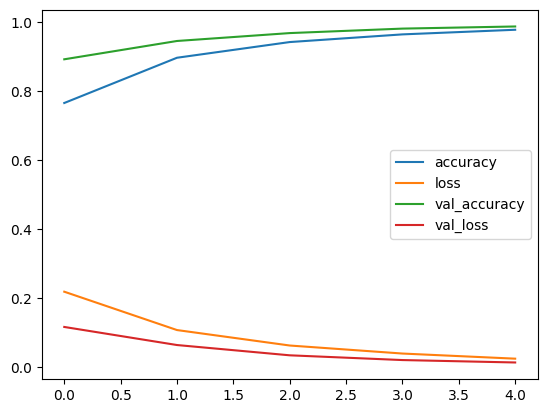

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
model.summary()

history = model.fit(train, epochs=5, validation_data=val)

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Embedding


# Modeli tanımla
cnn_model = Sequential()
cnn_model.add(Embedding(MAX_FEATURES + 1, 32))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(5, activation='sigmoid'))

# Modeli derle
cnn_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
cnn_model.summary()

# Modeli eğit
cnn_history = cnn_model.fit(train, epochs=5, validation_data=val)

# Eğitim geçmişini görselleştir
plt.figure(figsize=(8, 5))
pd.DataFrame(cnn_history.history).plot()
plt.show()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 141s 41ms/step - accuracy: 0.6926 - loss: 0.2766 - val_accuracy: 0.8907 - val_loss: 0.1171
Epoch 2/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 115s 34ms/step - accuracy: 0.8925 - loss: 0.1139 - val_accuracy: 0.9417 - val_loss: 0.0648
Epoch 3/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 116s 34ms/step - accuracy: 0.9446 - loss: 0.0608 - val_accuracy: 0.9699 - val_loss: 0.0341
Epoch 4/5
3404/3404 ━━━━━━━━━━━━━━━━━━━━ 116s 34ms/step - accuracy: 0.9680 - loss: 0.0361 - val_accuracy: 0.9815 - val_loss: 0.0218
Epoch 5/5
1170/3404 ━━━━━━━━━━━━━━━━━━━━ 1:11 32ms/step - accuracy: 0.9832 - loss: 0.0211

In [ ]:
import tensorflow as tf
cnn_model.save('model.h5')
